<a href="https://colab.research.google.com/github/mkhfring/parallel-c/blob/main/A6_(2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A6 (15 Marks + 5 Bonus Marks)
---
**Focus**: CUDA(C) - Thread organization

© Dr. Abdallah Mohamed

This assignment aims to compute the normal Julia set that can be represented in an image similar to the one provided below:

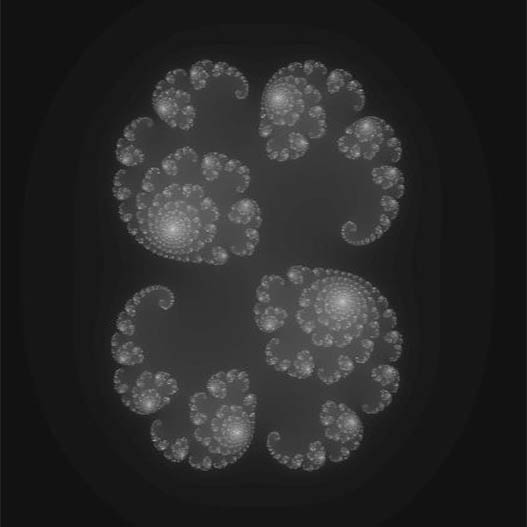

To get started on this assignment:

1. Run the Notebook Setup cell to prepare the notebook for this assignment. This setup cell installs the NVCC4Jupyter plugin (which you should have seen before in the previous assignment) and also downloads the relevant header files which leverage EasyBMP [1].

2. Run the Julia Set code block below which features the serial version of the Julia set algorithm.

3. Check the output bmp image named test.bmp by running the "Show Image" code block or by downloading/viewing the image through the Colab file explorer (click on the file icon located on the left sidebar, right-click test.bmp, and click download).

4. Familiarize yourself with the code in Julia Set code block. Comments are provided in order to explain how the code works. There is no need to read the code in the other downloaded files.
  
  a. *Optional:* See the extra information provided below for the bonus portion of this assignment.

[1] The full EasyBMP library and samples can be downloaded from https://easybmp.sourceforge.net. You don’t need the full library as the required files are already attached to this assignment.

## **What to Submit**

- CUDA implementation that performs the same computation as the given code using 1 thread per pixel.
(see the comments in Julia_set_serial.cu for the part that needs to be parallelized).

- The output image from your CUDA code in BMP format.

## **Marking Guide**

+2 marks for properly declaring the functions

+4 for kernel launch configuration

+2 for getting the right pixel location and assigning one thread per pixel

+3 for allocating, copying, and freeing device memory

+1 for submitting the output image with a proper Julia set.

+3 for overall correctness

---

## **Assignment Bonus**

Up to +5 bonus marks for modifying your code in order to set different colors to the pixels with the different values in the Julia set (especially at the boundaries). See the example below, although your image doesn’t have to match this one.

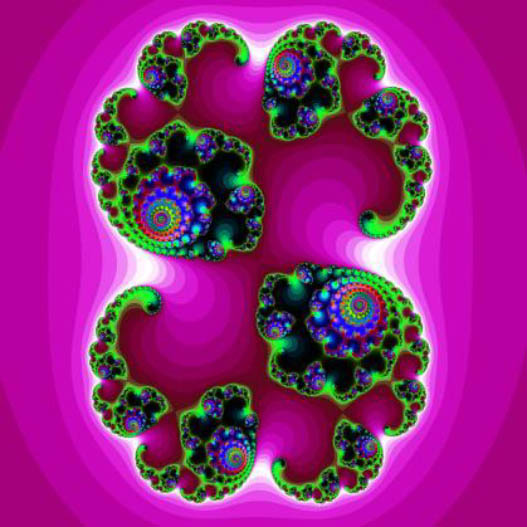

More information about the used algorithm: (you don’t need to fully understand this part in order to solve the question): The Julia set in the question is computed using the function 𝑓(𝑧) = 𝑧^2 + 𝑐. Both z and c are complex numbers, where the real and imaginary values are represented on the x-y axis. The code computes a 1024x768 matrix storing the image corresponding to the complex plane. Other Julia sets can be generated by changing the value of c in the function 𝑓(𝑧) = 𝑧^2 + 𝑐. See http://en.wikipedia.org/wiki/Julia_set

## Notebook Setup

**Remember to re-run the following code block anytime you reconnect/connect/restart your Notebook!**

In [1]:
# Download/Install/Enable NVCC4Jupyter

!pip install git+https://github.com/engasa/nvcc4jupyter.git
%load_ext nvcc_plugin

# Download/UnZip EasyBMP
!curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=1dGhBQsqwvtTqwDyhWhYnuhy4ud75tH5F" > /dev/null
!curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=1dGhBQsqwvtTqwDyhWhYnuhy4ud75tH5F" -o EasyBMP.zip
!unzip EasyBMP.zip -d ./src
!echo Finished!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/engasa/nvcc4jupyter.git to /tmp/pip-req-build-f0tyjd9m
  Running command git clone -q https://github.com/engasa/nvcc4jupyter.git /tmp/pip-req-build-f0tyjd9m
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4407 sha256=a4b2f1f79a0801c8123e4282054b000da72194e539de250358dc561b35ec80eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_sxstlr/wheels/d2/a3/04/ef659d715dcdd196d998813ca085af3cab3df66f4bb27576b5
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out
awk: cannot open ./cookie (No such file or directory)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 46313  100 46313    0     0  77836    

## Julia Set Code

In [49]:
%%cuda --name Julia_set.cu --compile true

#include <stdio.h>
#include "EasyBMP.h"
#include "EasyBMP.cu"

//Complex number definition
struct Complex {	// typedef is not required for C++
	float x; 				// real part is represented on x-axis in output image
	float y; 				// imaginary part is represented by y-axis in output image
};

//Function declarations
void compute_julia(const char*, int, int);
void save_image(uchar4*, const char*, int, int);
__host__ __device__ Complex add(Complex, Complex);
__host__ __device__ Complex mul(Complex, Complex);
__host__ __device__ float mag(Complex);

//main function
int main(void) {
	char* name = "test.bmp";
	compute_julia(name, 100, 100);	//width x height
	printf("Finished creating %s.\n", name);
	return 0;
}

// serial implementation of Julia set
__global__ void compute_julia_cuda(int width, int height, float x_min, float y_min, float x_incr, float y_incr, uchar4 *p, int infinity, int max_iterations, Complex c1){
		int col = blockIdx.x * blockDim.x + threadIdx.x;
		int row = blockIdx.y * blockDim.y + threadIdx.y;
		if (col < width && row < height){		
				Complex z;
				z.x = x_min + col * x_incr;
				z.y = y_min + row * y_incr;
				int n = 0;
				do{
					z = add(mul(z, z), c1);								// z = z^2 + c
				} while (mag(z) < infinity && n++ < max_iterations);	// keep looping until z->infinity or we reach max_iterations
				if (n == max_iterations) {								// if we reach max_iterations before z reaches infinity, pixel is black 
					p[col + row * width] = { 0,0,0,0 };
				} else {												// if z reaches infinity, pixel color is based on how long it takes z to go to infinity
					unsigned char hue = (unsigned char)(255 * sqrt((float)n / max_iterations));
					p[col + row * width] = { hue,hue,hue,255 };
				}
				if (col < 3 && row < 3){
						printf("the value of z is %.1f\n", z.y);

				}
				
		}
}


void compute_julia(const char* filename, int width, int height) {
	//create output image
	uchar4 *pixels = (uchar4*)malloc(width * height * sizeof(uchar4));	//uchar4 is a CUDA type representing a vector of 4 chars

	//PROBLEM SETTINGS (marked by '******')
	// **** Accuracy ****: lower values give less accuracy but faster performance
	int max_iterations = 400;
	int infinity = 20;													//used to check if z goes towards infinity

	// ***** Shape ****: other values produce different patterns. See https://en.wikipedia.org/wiki/Julia_set
	Complex c = { 0.285, 0.01 }; 										//the constant in z = z^2 + c

	// ***** Size ****: higher w means smaller size
	float w = 4;
	float h = w * height / width;										//preserve aspect ratio

	// LIMITS for each pixel
	float x_min = -w / 2, y_min = -h / 2;
	float x_incr = w / width, y_incr = h / height;
	
	//****************************************************
	//REQ: Parallelize the following for loop using CUDA 
	//****************************************************
	uchar4 *d_pixels;
	int size = width * height * sizeof(uchar4);
	cudaMalloc(&d_pixels, size);
	cudaMemcpy(d_pixels, pixels, size, cudaMemcpyHostToDevice);
	dim3 grid, block;
	block.x = 32;	
	block.y = 32;
	grid.x = (width -1) / block.x + 1;
	grid.y = (width -1) / block.y + 1;
	compute_julia_cuda<<<grid, block>>>(width, height, x_min, y_min, x_incr, y_incr, d_pixels, infinity, max_iterations, c);
	cudaDeviceSynchronize();
	for (int row = 0; row < height; row++) {						// For each pixel in image, compute pixel color
		for (int col = 0; col < width; col++) {
			Complex z;
			z.x = x_min + col * x_incr;
			z.y = y_min + row * y_incr;

			//iteratively compute z = z^2 + c and check if z goes to infinity
			int n = 0;
			do{
				z = add(mul(z, z), c);								// z = z^2 + c
			} while (mag(z) < infinity && n++ < max_iterations);	// keep looping until z->infinity or we reach max_iterations
			
			// color each pixel based on above loop
			if (n == max_iterations) {								// if we reach max_iterations before z reaches infinity, pixel is black 
				pixels[col + row * width] = { 0,0,0,0 };
			} else {												// if z reaches infinity, pixel color is based on how long it takes z to go to infinity
				unsigned char hue = (unsigned char)(255 * sqrt((float)n / max_iterations));
				pixels[col + row * width] = { hue,hue,hue,255 };
			}
		}
	}
	
	//Write output image to a file (DO NOT parallelize this function)
	save_image(pixels, filename, width, height);

	//free memory
	free(pixels);
}

void save_image(uchar4* pixels, const char* filename, int width, int height) {
	BMP output;
	output.SetSize(width, height);
	output.SetBitDepth(24);
	// save each pixel to output image
	for (int row = 0; row < height; row++) {
		for (int col = 0; col < width; col++) {
			uchar4 color = pixels[col + row * width];
			output(col, row)->Red = color.x;
			output(col, row)->Green = color.y;
			output(col, row)->Blue = color.z;
		}
	}
	output.WriteToFile(filename);
}

__host__ __device__ Complex add(Complex c1, Complex c2) {
	return{ c1.x + c2.x, c1.y + c2.y };
}

__host__ __device__ Complex mul(Complex c1, Complex c2) {
	return{ c1.x * c2.x - c1.y * c2.y, c1.x * c2.y + c2.x * c1.y };
}

__host__ __device__ float mag(Complex c) {
	return (float)sqrt((double)(c.x * c.x + c.y * c.y));
}



/content/src/EasyBMP.cu(1128): warning: variable "ZeroWORD" was declared but never referenced

/content/src/Julia_set.cu(21): warning: conversion from a string literal to "char *" is deprecated

/content/src/Julia_set.cu(21): warning: conversion from a string literal to "char *" is deprecated


the value of z is 4.6
the value of z is 2.0
the value of z is -0.4
the value of z is 7.0
the value of z is 4.4
the value of z is 2.0
the value of z is 9.2
the value of z is 6.6
the value of z is 4.2
Finished creating test.bmp.



## Show Image

To display the created test.bmp image, run the code block below

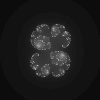

In [ ]:
from PIL import Image
Image.open("test.bmp")

---

**Submission instructions**

For this assignment, you need to do the following:

1. Copy and paste the Julia Set code block into a text file on your local machine and name it Julia_set.cu

2. Download the image generated by your CUDA Julia Set code (this can be done by right-clicking/saving the displayed by the above code block).

3. Compress all your files (the source code and the image) into one zip file and give it a name that matches your ID (e.g., 1234567.zip).

2. Submit the zipped file to Canvas.

Note that you can resubmit an assignment, but the new submission overwrites the old submission and receives a new timestamp.